## Project: Detection of Powder Mildew Diesase in Leaves using Convultion Nerual Network

* Objective: Detection...
* Input: Images of Cherry
* Output: Prediction of Normal/Powder mildew diease

## Load Data From Kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [ ]:
! kaggle datasets download codeinstitute/cherry-leaves

 75% 41.0M/55.0M [00:00<00:00, 64.1MB/s]
100% 55.0M/55.0M [00:00<00:00, 71.1MB/s]


## Extract Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('/content/cherry-leaves.zip', 'r') as zip_ref:
    zip_ref.extractall('plant')

## Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [ ]:
dataset_dir = '/content/plant/cherry-leaves'
healthy_dir = os.path.join(dataset_dir, 'healthy')
mildew_dir = os.path.join(dataset_dir, 'powdery_mildew')

## Loading Images

In [ ]:
healthy_images = [os.path.join(healthy_dir, file) for file in os.listdir(healthy_dir)]
mildew_images = [os.path.join(mildew_dir, file) for file in os.listdir(mildew_dir)]

## Data Visulization

In [ ]:
def display_images(image_paths, title='Images'):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        if i >= len(image_paths):
            break
        plt.subplot(3, 3, i + 1)
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

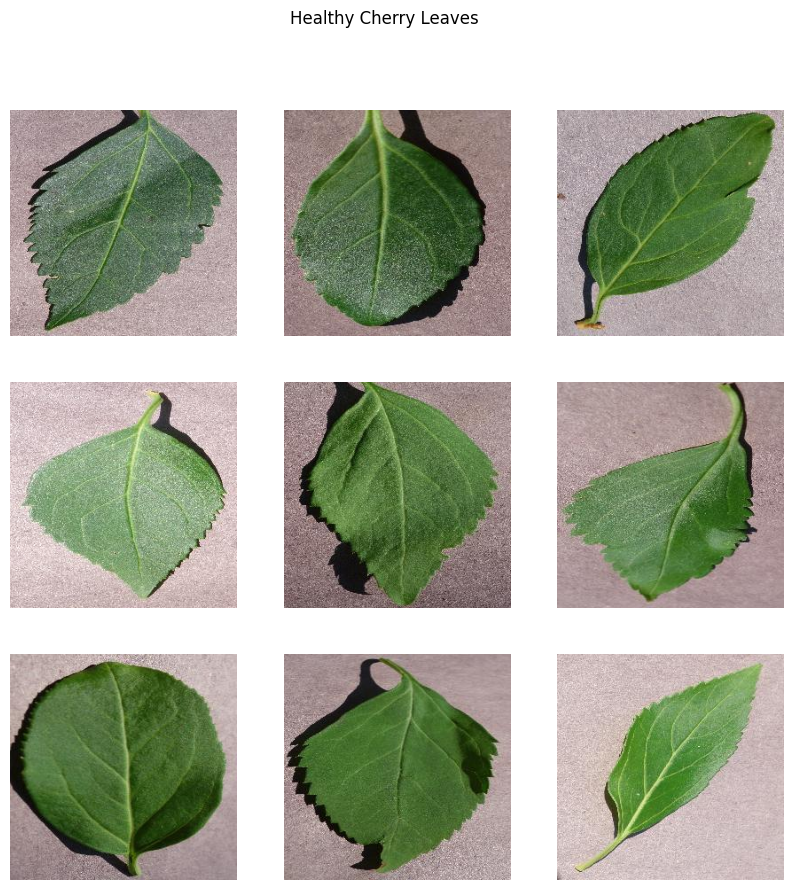

In [ ]:
display_images(healthy_images, title='Healthy Cherry Leaves')

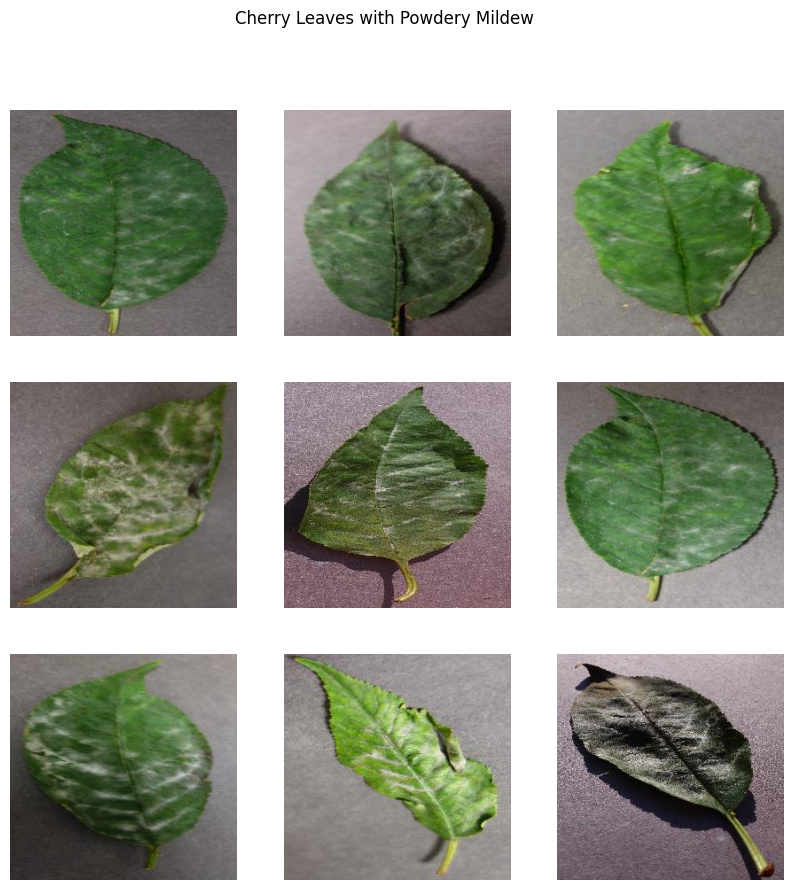

In [ ]:
display_images(mildew_images, title='Cherry Leaves with Powdery Mildew')

## Checking Class Balance

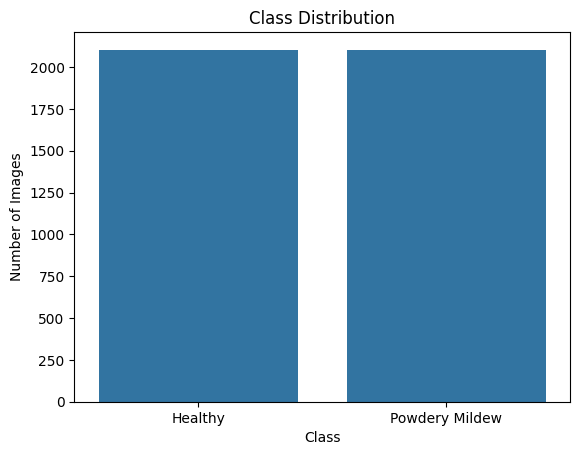

In [ ]:
class_counts = [len(healthy_images), len(mildew_images)]
class_names = ['Healthy', 'Powdery Mildew']

sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Average Color Distribution

*  Average color channels of healthy and mildew leaves


In [ ]:
def compute_average_image_color(image_paths):
    average_colors = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        average_colors.append(np.mean(img, axis=(0, 1)))
    return np.array(average_colors)

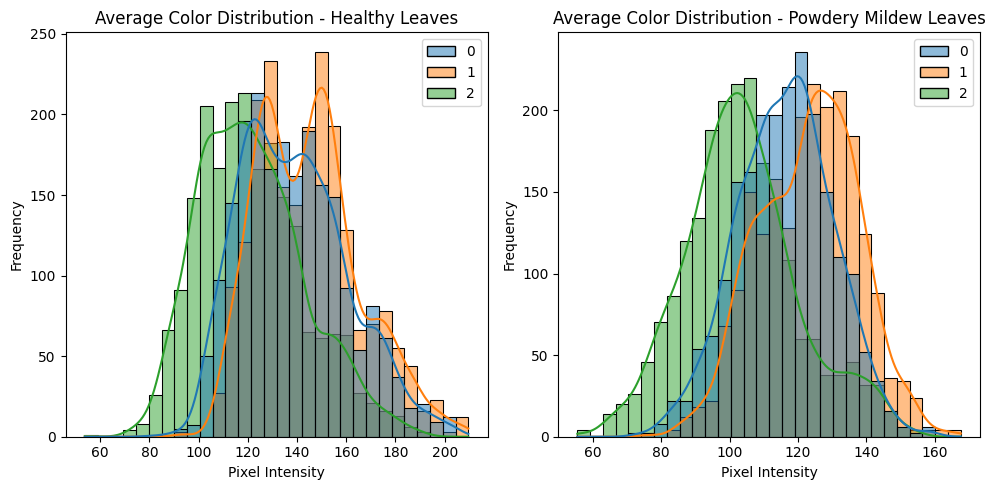

In [ ]:
healthy_avg_color = compute_average_image_color(healthy_images)
mildew_avg_color = compute_average_image_color(mildew_images)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(healthy_avg_color, bins=30, kde=True)
plt.title('Average Color Distribution - Healthy Leaves')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(mildew_avg_color, bins=30, kde=True)
plt.title('Average Color Distribution - Powdery Mildew Leaves')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Model Training

In [ ]:
## Image Size and Batch
img_width, img_height = 128, 128 ## Shape
batch_size = 32

## Creating Training Data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=40,      # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest',    # Strategy for filling newly created pixels
    validation_split=0.2    # Reserve 20% of images for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

Found 3368 images belonging to 2 classes.


## Creating Validation Data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

Found 840 images belonging to 2 classes.


## Creating Test Data

In [ ]:
def split_validation_set(generator, split_size=0.5):
    data_list = []
    labels_list = []
    batch_index = 0

    while batch_index <= generator.batch_index:
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
        batch_index = batch_index + 1

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)

    split_index = int(len(data_array) * split_size)

    validation_data = data_array[:split_index]
    validation_labels = labels_array[:split_index]
    test_data = data_array[split_index:]
    test_labels = labels_array[split_index:]

    return (validation_data, validation_labels), (test_data, test_labels)

In [ ]:
(validation_data, validation_labels), (test_data, test_labels) = split_validation_set(validation_generator)

## Creating Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Model Summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_10 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

## Complie Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Early Stopping Method

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True) ##Early stopping as a technique to prevent overfitting

## Training Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
105/105 [==============================] - 24s 209ms/step - loss: 0.4127 - accuracy: 0.7851 - val_loss: 0.0824 - val_accuracy: 0.9796
Epoch 2/10
105/105 [==============================] - 21s 200ms/step - loss: 0.1171 - accuracy: 0.9622 - val_loss: 0.0507 - val_accuracy: 0.9856
Epoch 3/10
105/105 [==============================] - 24s 227ms/step - loss: 0.1230 - accuracy: 0.9619 - val_loss: 0.0750 - val_accuracy: 0.9760
Epoch 4/10
105/105 [==============================] - 24s 231ms/step - loss: 0.0658 - accuracy: 0.9802 - val_loss: 0.0612 - val_accuracy: 0.9856
Epoch 4: early stopping


## Model Loss and Accuracy

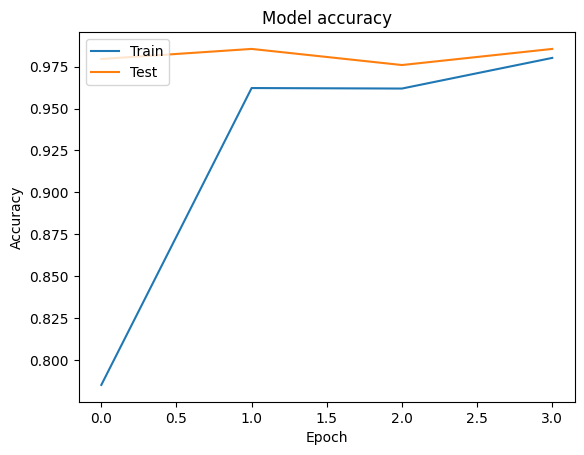

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

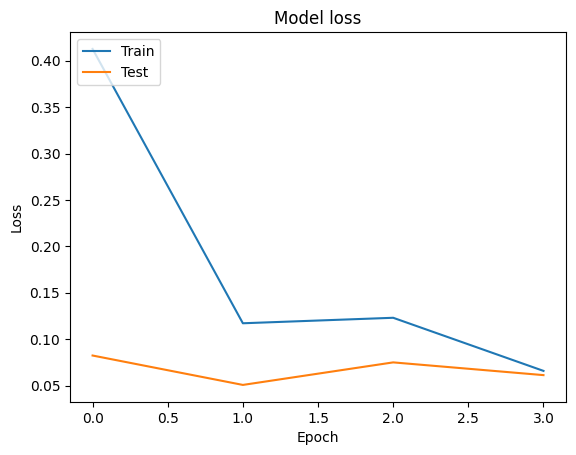

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 [==============================] - 0s 23ms/step - loss: 0.0683 - accuracy: 0.9786
Test Accuracy: 0.9786
Test Loss: 0.0683


## Confusion Matrix

14/14 [==============================] - 0s 10ms/step


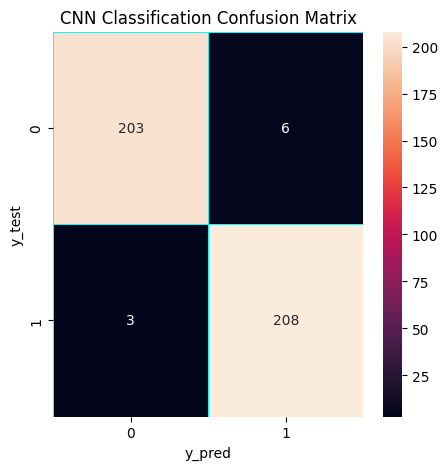

In [ ]:
test_predictions = model.predict(test_data)
test_predictions = np.round(test_predictions).astype(int)

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize = (5, 5))
sns.heatmap(conf_matrix, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f')
plt.title('CNN Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
print("\nClassification Report:")
class_report = classification_report(test_labels, test_predictions)
print(class_report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       209
         1.0       0.97      0.99      0.98       211

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



## Save Model

In [ ]:
model.save('cherry_leaf_model.h5')
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!
